In [23]:
import os
import nibabel as nib
import numpy as np
import nilearn
from nilearn import image
import pandas as pd
from hampel import hampel
import scipy.stats as stats
import matplotlib.pyplot as plt

In [24]:
# sub = 'all'
# data_dir = '/arc/project/st-ipor-1/mkhademi/BOLD5000_2.0/'
# output_dir = '/scratch/st-ipor-1/mkhademi/'
output_dir = 'C:\\Users\\mahkh\\Documents\\'
roi_dir = output_dir + 'image_data\\parcels\\'
subjs = ['CSI1', 'CSI2', 'CSI3', 'CSI4']
sub = subjs[2]
#roi_names =['lFFA','lOFA','lSTS','lLOC','lPPA','lRSC','lTOS','lEBA','rFFA','rOFA','rSTS','rLOC','rPPA','rRSC','rTOS','rEBA']
roi_names = ['lFFA','rFFA','lOFA','rOFA','lSTS','rSTS','lLOC','rLOC','lPPA','rPPA','lRSC','rRSC','lTOS','rTOS','lEBA','rEBA']
roi_voxels = {'lFFA': 531, 'rFFA': 1019, 'lOFA': 211, 'rOFA': 790, 'lSTS': 844, 'rSTS': 2505, 'lLOC': 4971, 'rLOC': 5085,
             'lPPA': 732, 'rPPA': 553, 'lRSC': 1063, 'rRSC': 1741, 'lTOS': 133, 'rTOS': 251, 'lEBA': 2155, 'rEBA': 2413}
supcat_names = {91: 'vehicle', 93: 'animal', 0: 'person', 90: 'face', 92: 'outdoor', 95: 'sport', 97: 'food', 
                98: 'furniture',102: 'tool'}

In [25]:
def get_med_rois(sub, j):
    igs = nib.load(output_dir + 'image_data\\vis_\\igs-p-' + sub + '-c' + str(j) + '.nii.gz')
    igs = nilearn.image.resample_img(igs, target_shape=(79, 95, 69), target_affine=igs.affine)
    igs = np.array(igs.dataobj)
    #dif = dif[6:91-6, 7:109-7, 11:91-11]
    med_rois = []
    no_roi = np.ones((79, 95, 69), dtype=np.uint8)
    for roi_name in roi_names:
        roi = nib.load(roi_dir + roi_name + '.img')
        roi = np.array(roi.dataobj)
        no_roi[np.nonzero(roi)] = 0
        tmp = igs[np.nonzero(roi)]
        tmp[tmp == 0.0] = np.nan
        med_rois.append(np.nanmedian(tmp))

    tmp = igs[np.nonzero(no_roi)]
    tmp[tmp == 0.0] = np.nan
    med_rois.append(np.nanmedian(tmp))
    med_rois = np.array(med_rois)
    for i, roi_name in enumerate(roi_names): 
        #print(roi_name + ':', np.round(med_rois[i], 8))
        pass
    #print('rest' + ':', np.round(np.nanmedian(tmp), 8)) 
    return med_rois

In [26]:
def get_prop(sub, j, ig_type):
    igs = nib.load(output_dir + 'image_data\\vis_\\' + ig_type + '-' + sub + '-c' + str(j) + '.nii.gz')
    igs = nilearn.image.resample_img(igs, target_shape=(79, 95, 69), target_affine=igs.affine)
    igs = np.array(igs.dataobj)
    #igs = igs[6:91-6, 7:109-7, 11:91-11]

    tmp = igs.reshape(-1)
    tmp[tmp == 0.0] = np.nan
    tmp = tmp[~np.isnan(tmp)]
    p_pos = np.nanpercentile(tmp, 80)
    print("p_80", p_pos)
    n_p_pos = 0
    for x in tmp:
        if x > p_pos:
            n_p_pos += 1
    p_neg = np.nanpercentile(tmp, 20)
    print("p_20", p_neg)
    n_p_neg = 0
    for x in tmp:
        if x < p_neg:
            n_p_neg += 1

    igs_rois = []
    all_prop_pos = []
    all_prop_neg = []
    no_roi = np.ones((79, 95, 69), dtype=np.uint8)
    for roi_name in roi_names:
        roi = nib.load(roi_dir + roi_name + '.img')
        roi = np.array(roi.dataobj)
        no_roi[np.nonzero(roi)] = 0
        tmp = igs[np.nonzero(roi)].copy()
        tmp[tmp == 0.0] = np.nan
        tmp = tmp[~np.isnan(tmp)]
        igs_rois.append(np.nanmedian(tmp))
        prop = 0.0
        for x in tmp:
            if x >= p_pos:
                prop += 1
        if len(tmp) > 0:
            # all_prop_pos.append(prop/len(tmp))
            all_prop_pos.append(prop/n_p_pos)
        else:
            all_prop_pos.append(0.0)
        prop = 0.0
        for x in tmp:
            if x <= p_neg:
                prop += 1
        if len(tmp) > 0:
            # all_prop_neg.append(prop/len(tmp))
            all_prop_neg.append(prop/n_p_neg)
        else: 
            all_prop_neg.append(0.0)
    igs_rois = np.array(igs_rois)   
    tmp = igs[np.nonzero(no_roi)].copy()
    tmp[tmp == 0.0] = np.nan
    ##
    prop = 0.0
    for x in tmp:
        if x > p_pos:
            prop += 1
    # all_prop_pos.append(prop/len(tmp))
    all_prop_pos.append(prop/n_p_pos)
    ##
    print('\n')
    ##
    prop = 0.0
    for x in tmp:
        if x < p_neg:
            prop += 1
    #all_prop_neg.append(prop/len(tmp))
    all_prop_neg.append(prop/n_p_neg)
    ##
    # print('\nMedian IGs:')   
    # print('rest' + ':', np.round(np.nanmedian(tmp), 8))
    for i, roi_name in enumerate(roi_names): 
        #print(roi_name + ':', np.round(igs_rois[i], 8))
        pass
    return all_prop_pos, all_prop_neg

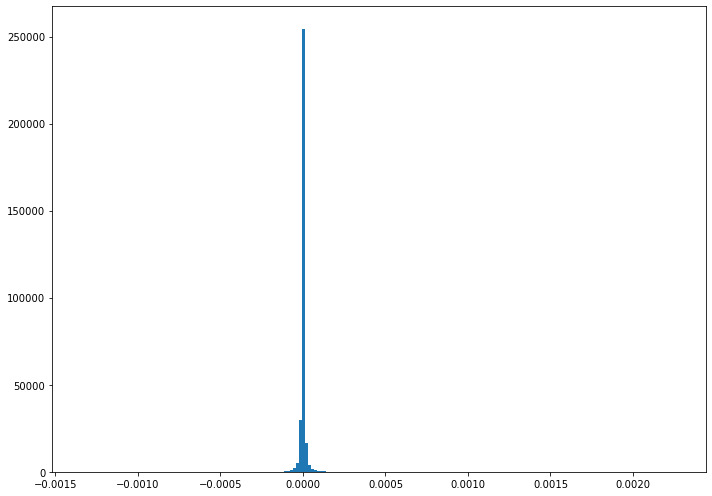

In [27]:
j = 90
igs = nib.load(output_dir + 'image_data/vis/igs-p-' + sub + '-c' + str(j) + '.nii.gz') 
igs = nilearn.image.resample_img(igs, target_shape=(79, 95, 69), target_affine=igs.affine)
igs = np.array(igs.dataobj)
#igs = igs[6:91-6, 7:109-7, 11:91-11]
tmp = igs.reshape(-1)
tmp[tmp == 0.0] = np.nan
tmp = tmp[~np.isnan(tmp)]
fig, axs = plt.subplots(1, 1, figsize =(10, 7), tight_layout = True)
axs.hist(tmp, bins=200)
# Show plot
plt.show()

In [28]:
def plot_igs(x_yes, x_no, t, y):
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.rc('font', size=10)
    ax = fig.add_axes([0,0,1,1])
    ax.set_ylabel(y)
    ax.set_xlabel('Brain ROIs')
    ax.set_title(sub + ': ' + supcat_names[j] + ' ' + t)
    x_pos = np.arange(len(roi_names)+1)*5
    ax.bar(x_pos, x_yes, align='center', color='blue', alpha=0.8, ecolor='black', capsize=10, width=2)
    # ax.bar(x_pos+2, x_no, align='center', color='red', alpha=0.8, ecolor='black', capsize=10, width=2)
    # ax.set_xticks(x_pos+1)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(roi_names +['Rest'])
    plt.show()

In [29]:
def plot_all(sub, j):
    all_prop_pos_yes, all_prop_neg_yes = get_prop(sub, j, ig_type='igs-p')
    all_prop_pos_no, all_prop_neg_no = get_prop(sub, j, ig_type='igs-n')
    all_prop_pos_yes, all_prop_neg_yes = np.array(all_prop_pos_yes), np.array(all_prop_neg_yes)
    all_prop_pos_no, all_prop_neg_no = np.array(all_prop_pos_no), np.array(all_prop_neg_no)
    plot_igs(np.log(all_prop_pos_yes), np.log(all_prop_pos_no), '(Correct YES IGs)', 'Log Proportion: Greater Than 80th Percentile')
    plot_igs(np.log(all_prop_neg_yes), np.log(all_prop_neg_no), '(Correct YES IGs)', 'Log Proportion: Less Than 20th Percentile')
    plot_igs(all_prop_pos_yes, all_prop_pos_no, '(Correct YES IGs)', 'Proportion: Greater Than 80th Percentile')
    plot_igs(all_prop_neg_yes, all_prop_neg_no, '(Correct YES IGs)', 'Proportion: Less Than 20th Percentile')
    arg1 = all_prop_pos_yes-all_prop_neg_yes
    arg2 = all_prop_pos_no-all_prop_neg_no
    plot_igs(arg1, arg2, '(Correct YES IGs)', 'Proportion: Greater Than 80th Percentile - Less Than 20th Percentile')
    med_rois = get_med_rois(sub, j)
    plot_igs(med_rois, med_rois, '(Correct YES IGs)', 'Median of IGs')
    return

p_80 1.1806787915702453e-05
p_20 -1.0307236880180416e-05


p_80 2.4532571842428295e-06
p_20 -2.7192470497539034e-06




C:\Users\mahkh\AppData\Local\Temp\ipykernel_27772\2421648554.py:6: RuntimeWarning: divide by zero encountered in log
  plot_igs(np.log(all_prop_pos_yes), np.log(all_prop_pos_no), '(Correct YES IGs)', 'Log Proportion: Greater Than 80th Percentile')


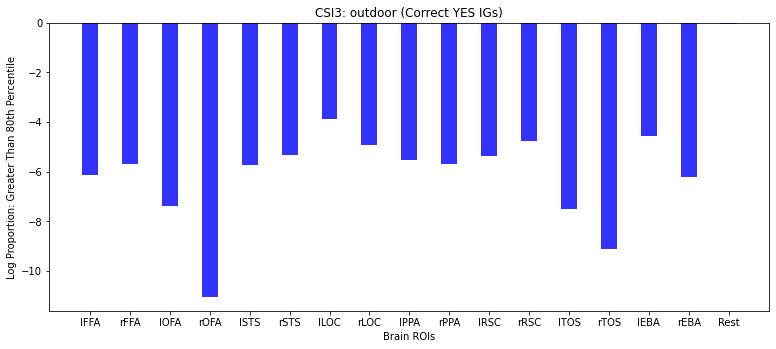

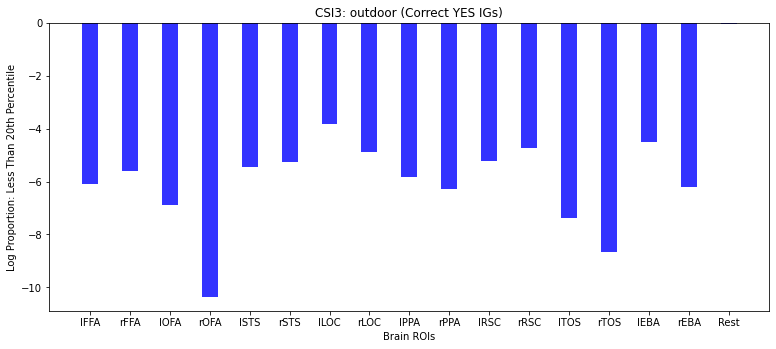

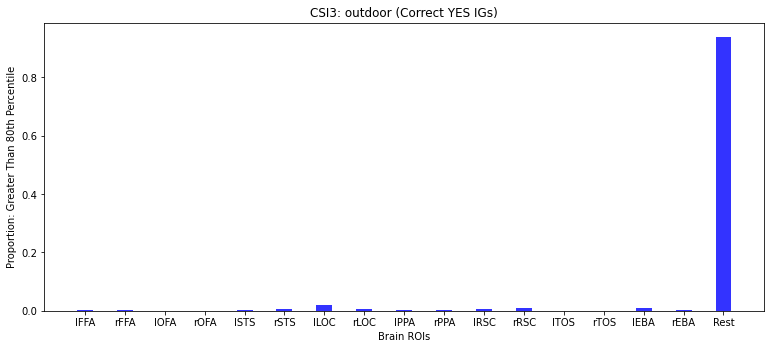

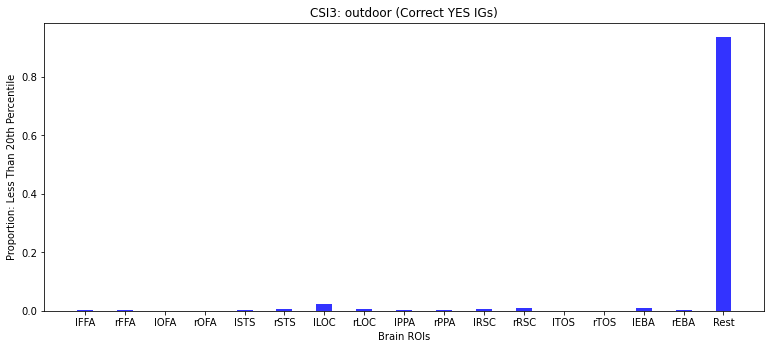

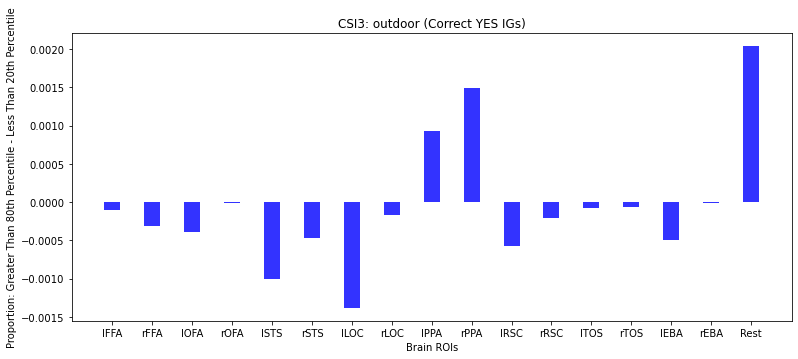

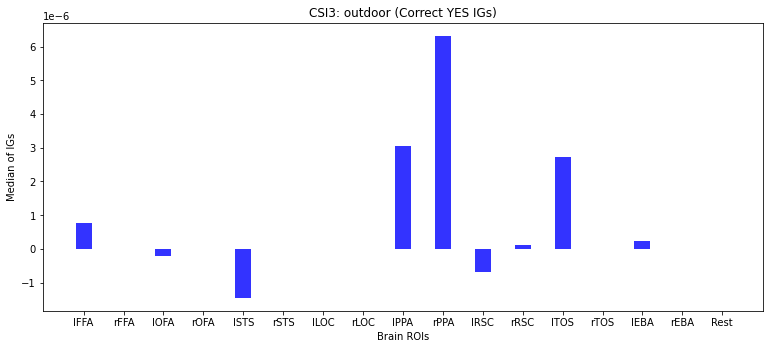

In [30]:
j = 92 # outdoor
plot_all(sub, j)

p_80 4.071872808708577e-06
p_20 -3.6793954222957835e-06


p_80 6.578591182915261e-06
p_20 -7.5071984610985965e-06




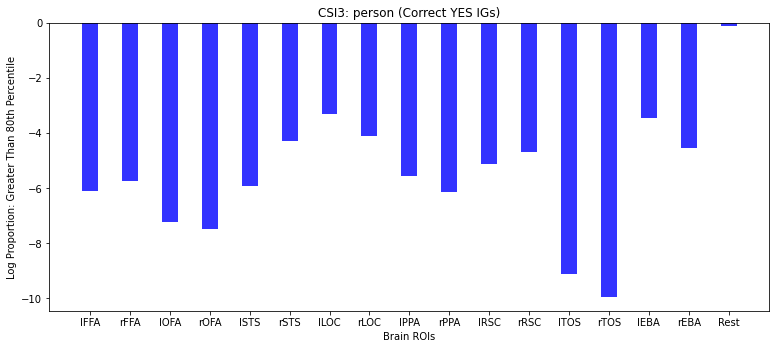

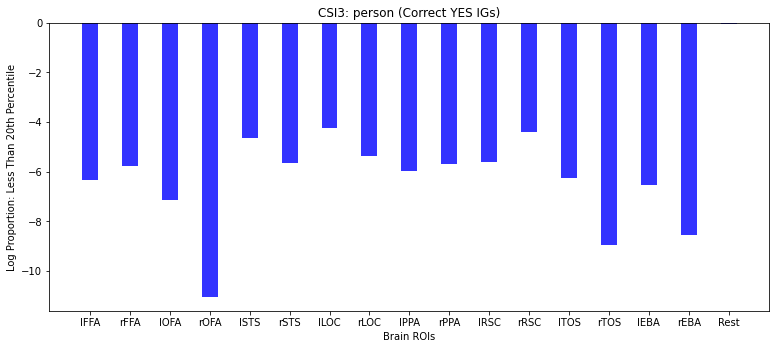

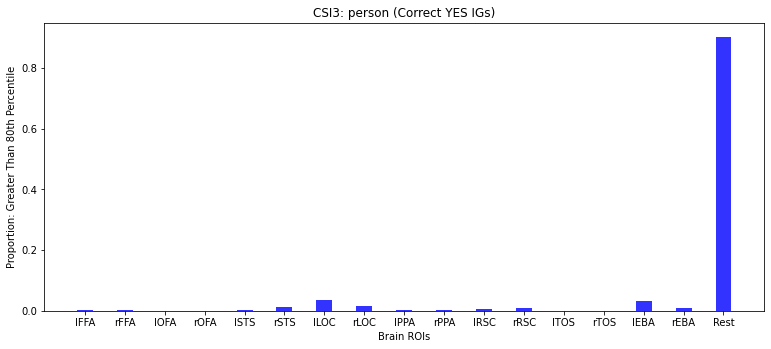

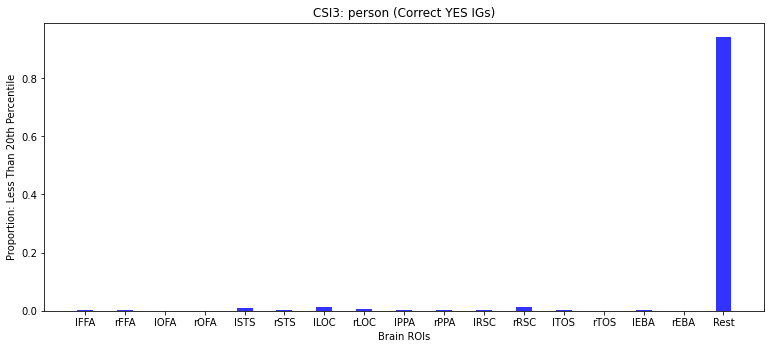

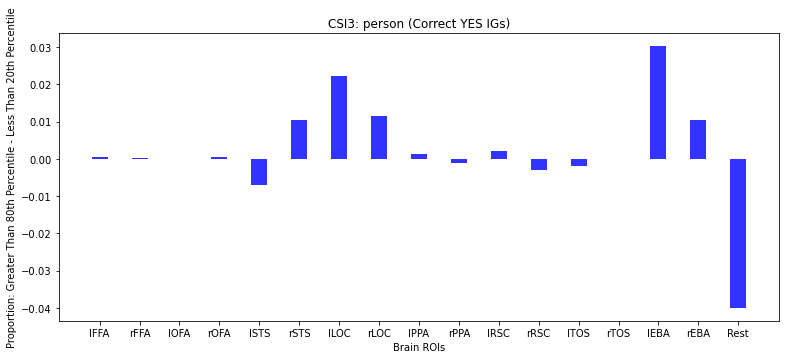

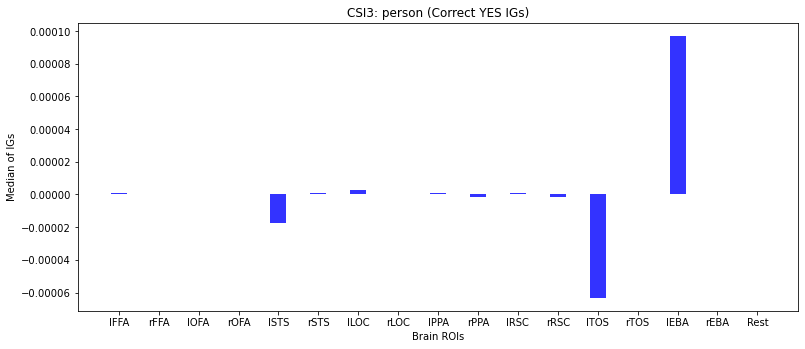

In [31]:
j = 0 # person
plot_all(sub, j)

p_80 8.61236967466539e-06
p_20 -7.75930420786608e-06


p_80 4.938702295476105e-06
p_20 -5.5541090659971815e-06




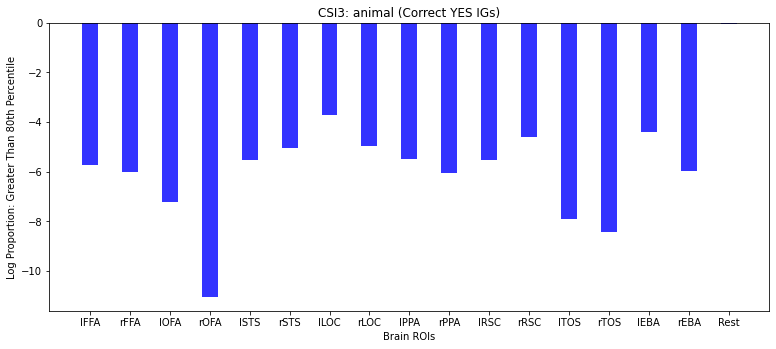

C:\Users\mahkh\AppData\Local\Temp\ipykernel_27772\2421648554.py:7: RuntimeWarning: divide by zero encountered in log
  plot_igs(np.log(all_prop_neg_yes), np.log(all_prop_neg_no), '(Correct YES IGs)', 'Log Proportion: Less Than 20th Percentile')


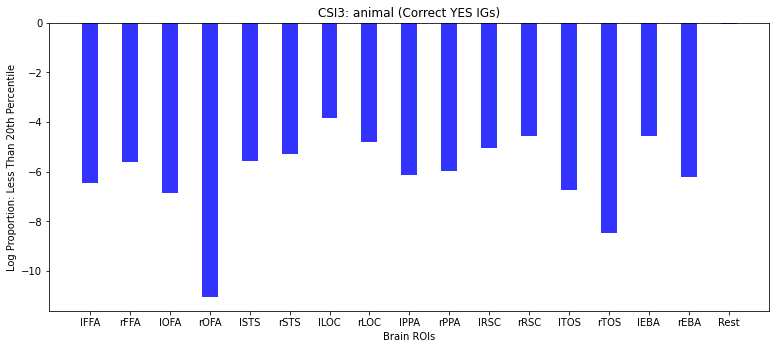

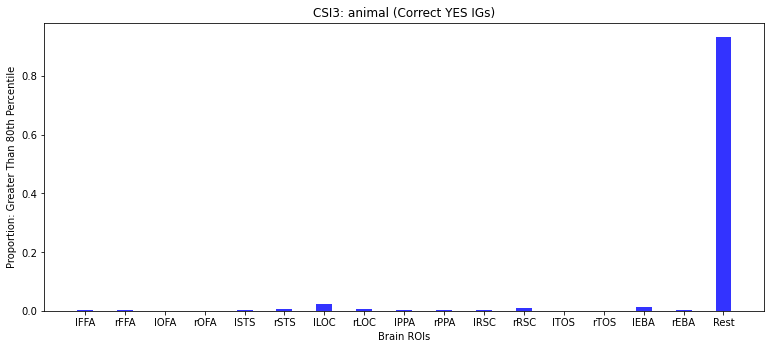

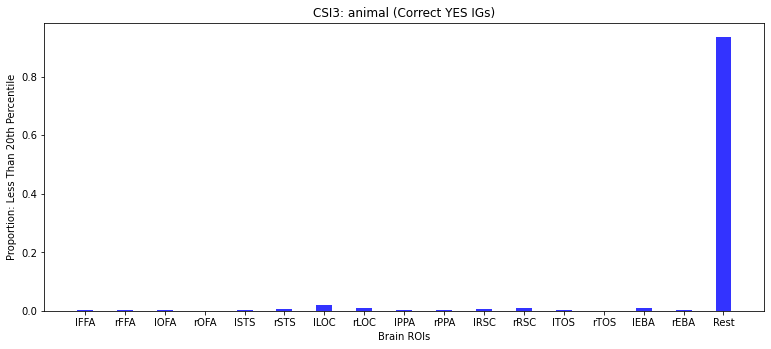

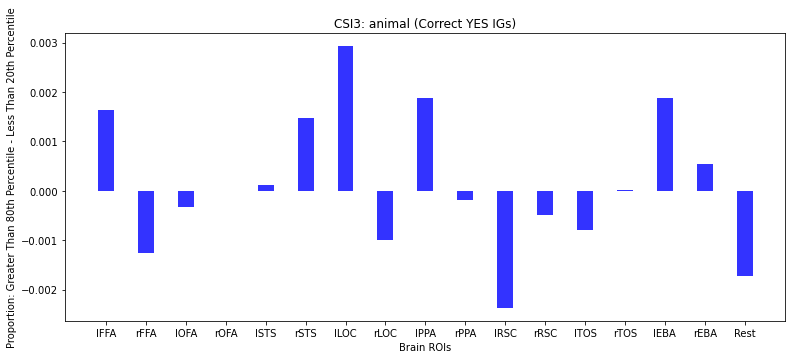

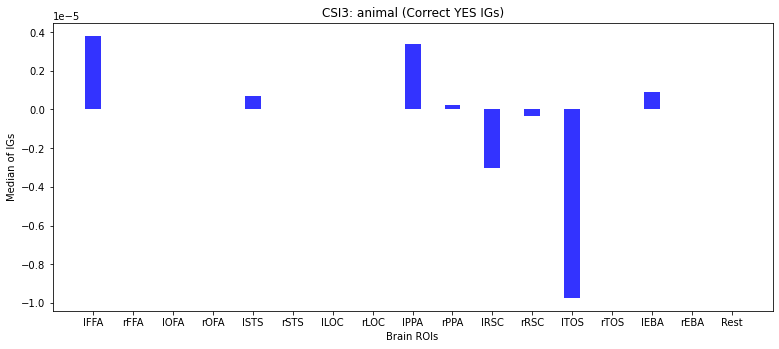

In [32]:
j = 93 # animal
plot_all(sub, j)

p_80 3.852415829896927e-06
p_20 -3.381940359759028e-06


p_80 3.5096755254926433e-06
p_20 -4.251901100360554e-06




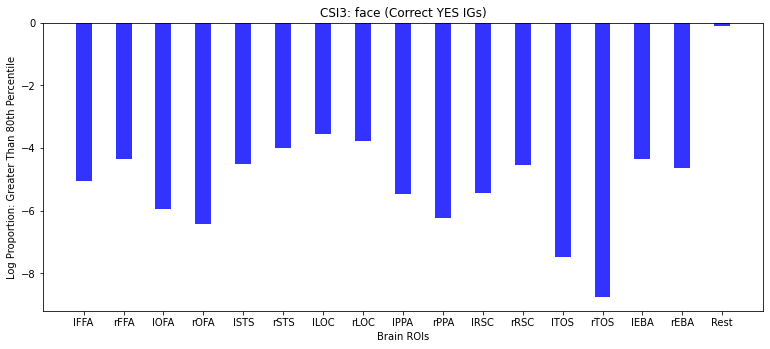

C:\Users\mahkh\AppData\Local\Temp\ipykernel_27772\2421648554.py:7: RuntimeWarning: divide by zero encountered in log
  plot_igs(np.log(all_prop_neg_yes), np.log(all_prop_neg_no), '(Correct YES IGs)', 'Log Proportion: Less Than 20th Percentile')


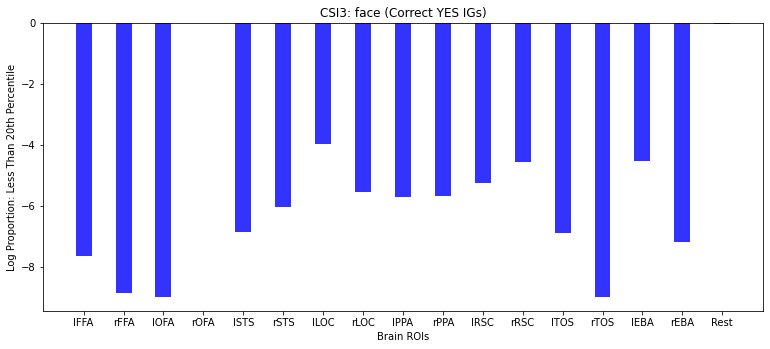

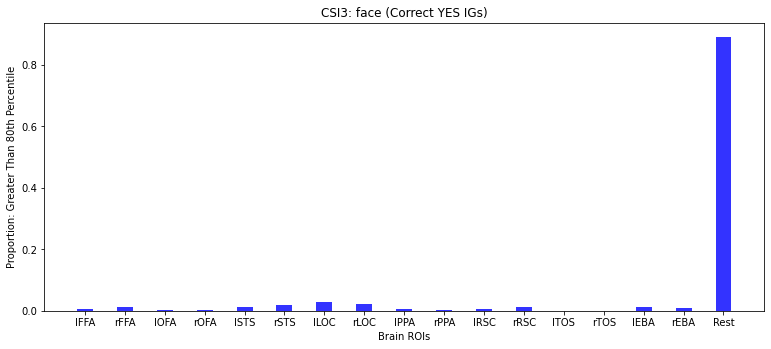

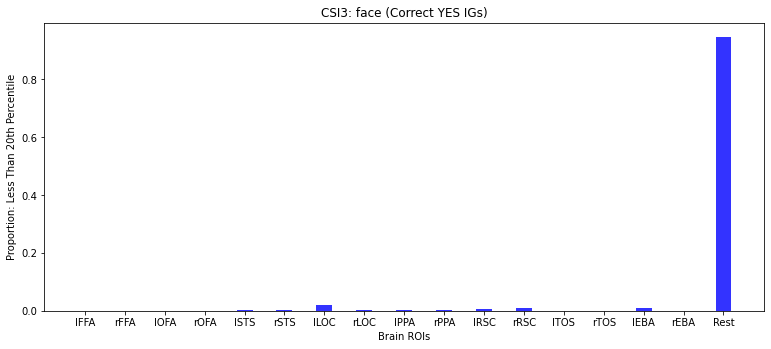

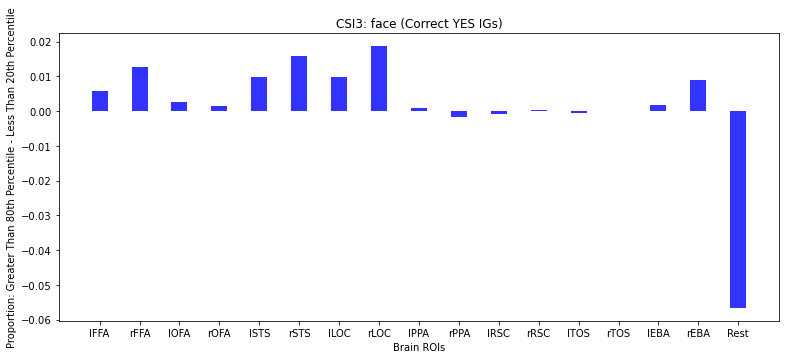

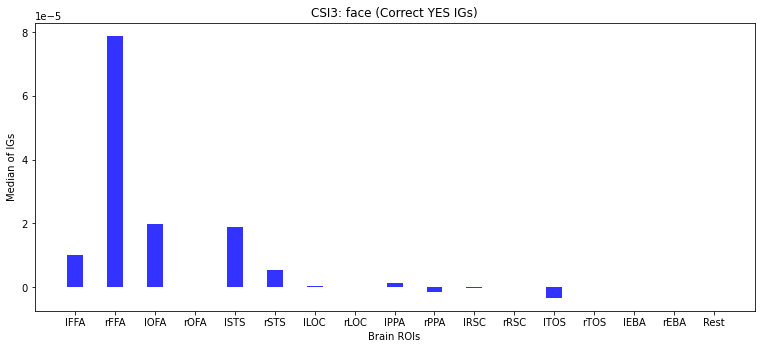

In [33]:
j = 90 # face
plot_all(sub, j)

p_80 1.0705531894927845e-05
p_20 -9.449749450141099e-06


p_80 9.224372115568268e-06
p_20 -1.0043859583674929e-05




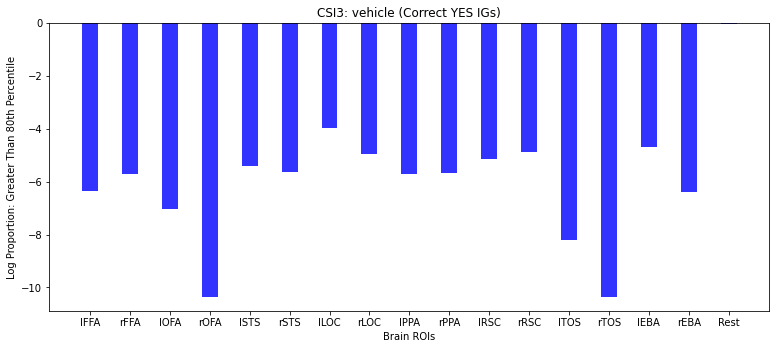

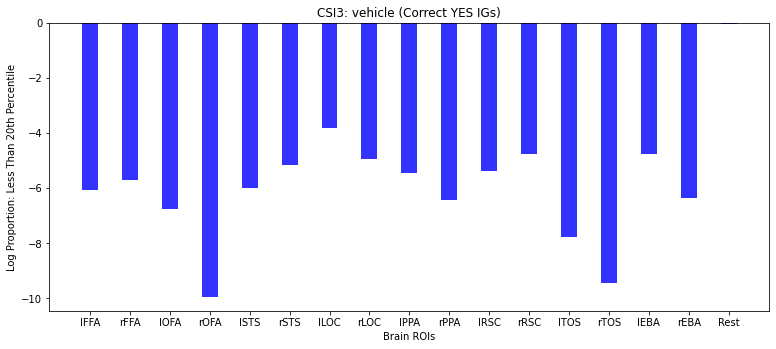

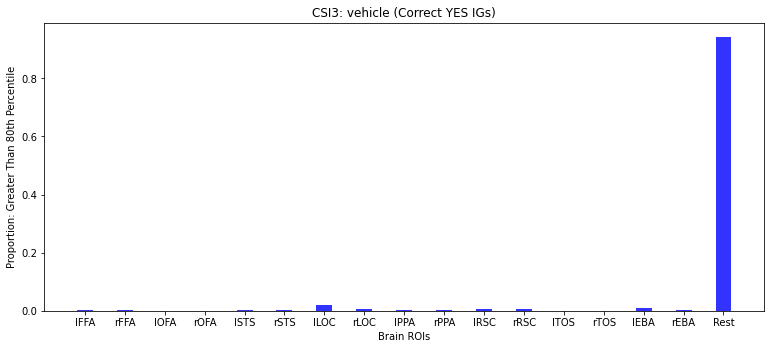

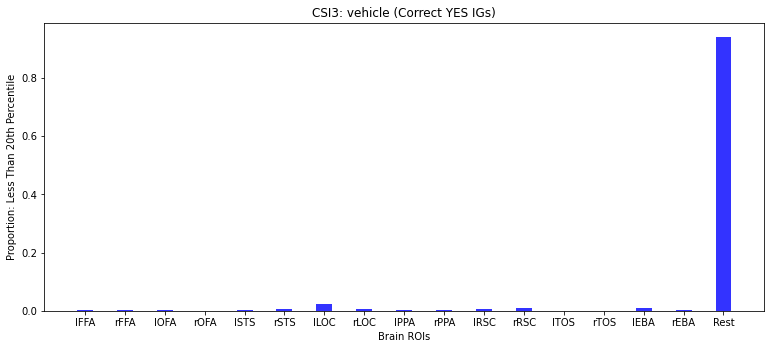

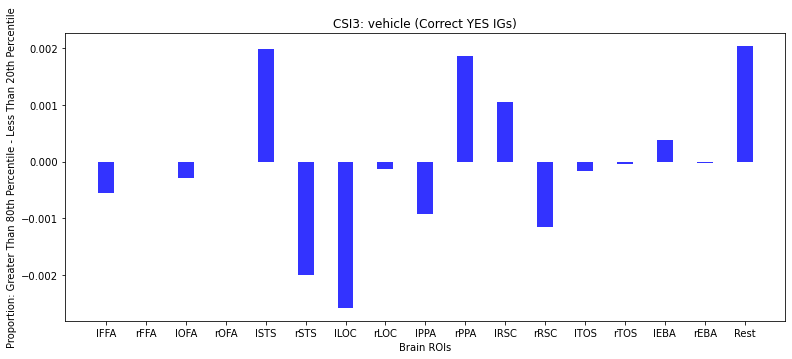

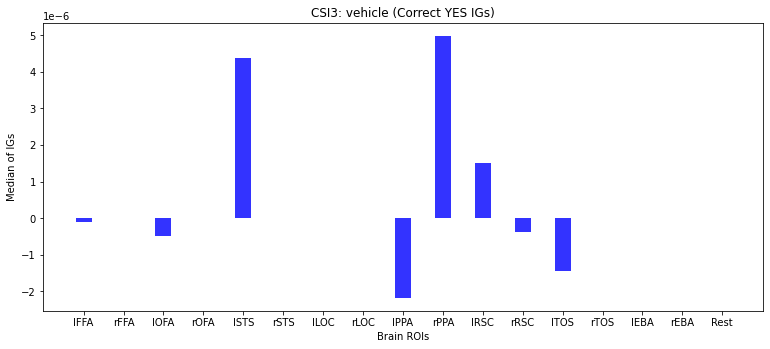

In [34]:
j = 91  # vehicle
plot_all(sub, j)

p_80 9.99900330498351e-06
p_20 -8.730439549253787e-06


p_80 4.143830574321328e-06
p_20 -4.52316753580817e-06




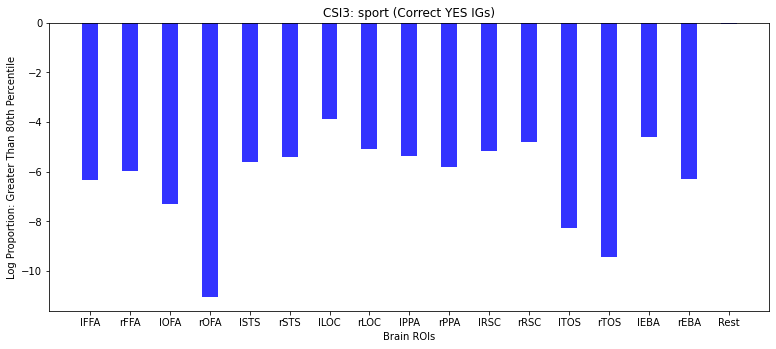

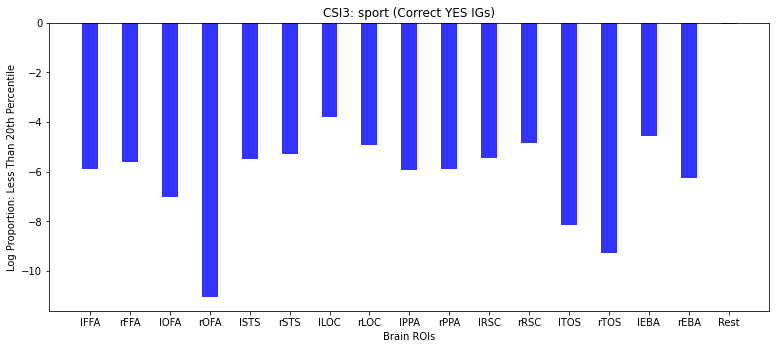

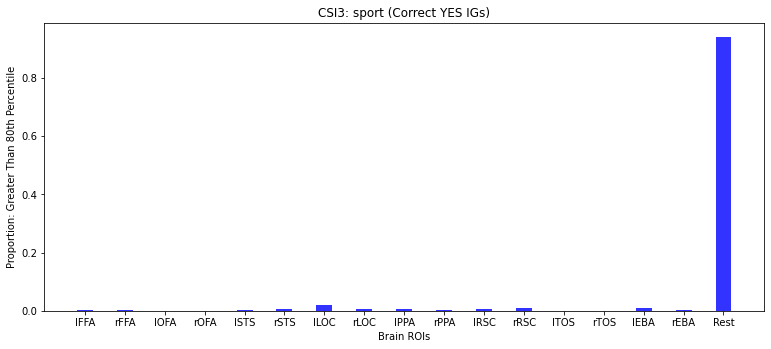

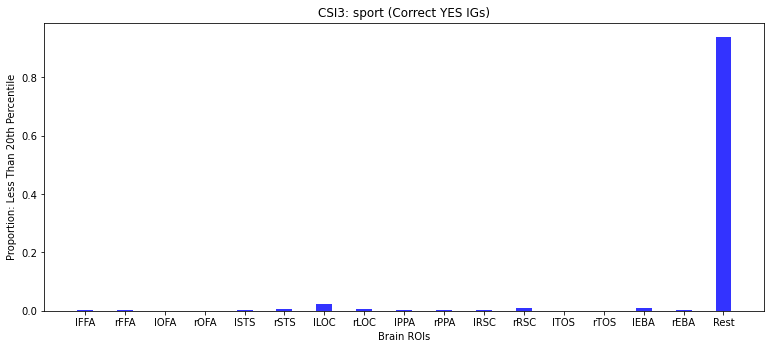

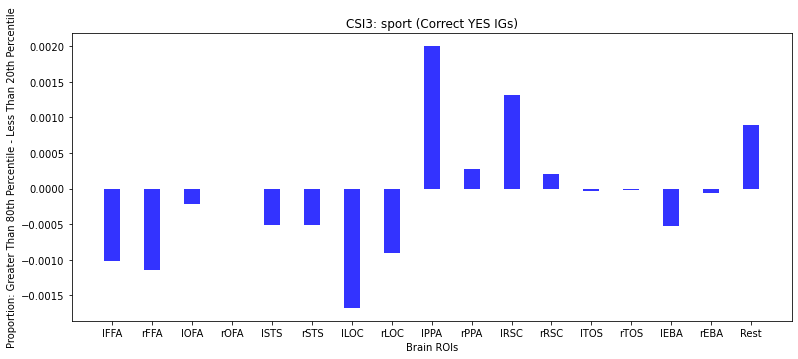

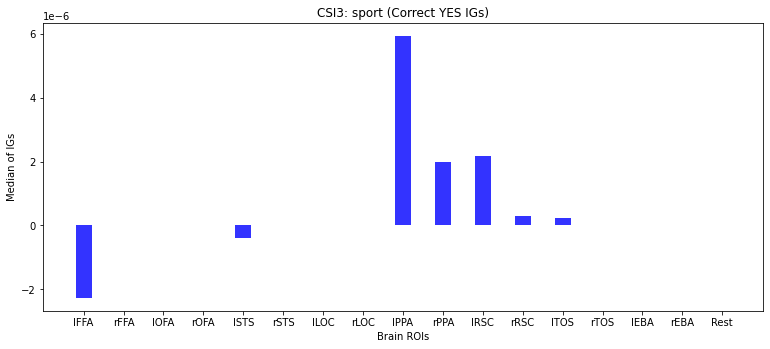

In [35]:
j = 95 # sport
plot_all(sub, j)

p_80 9.907201274472754e-06
p_20 -8.299293403979387e-06


p_80 1.9396265997784212e-06
p_20 -2.2784345219406532e-06




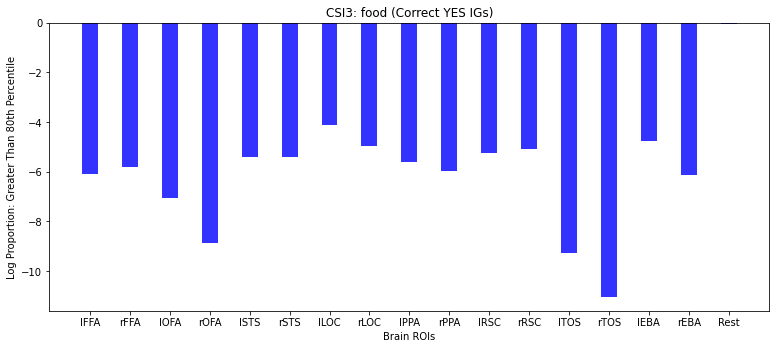

C:\Users\mahkh\AppData\Local\Temp\ipykernel_27772\2421648554.py:7: RuntimeWarning: divide by zero encountered in log
  plot_igs(np.log(all_prop_neg_yes), np.log(all_prop_neg_no), '(Correct YES IGs)', 'Log Proportion: Less Than 20th Percentile')


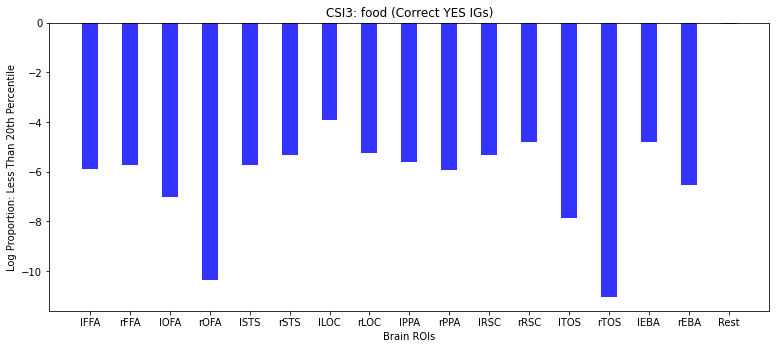

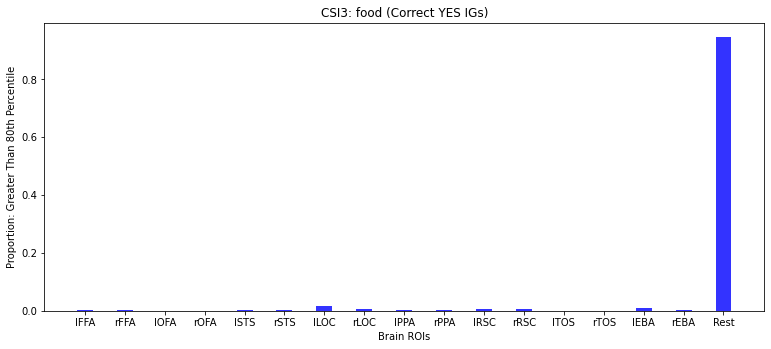

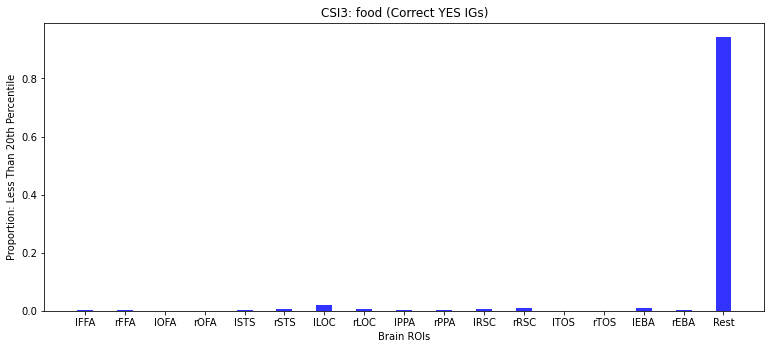

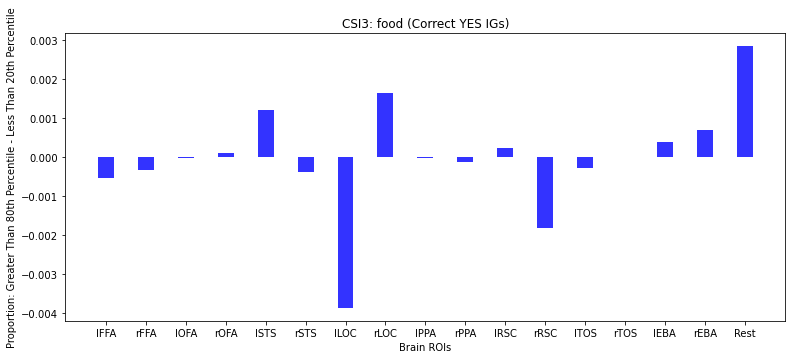

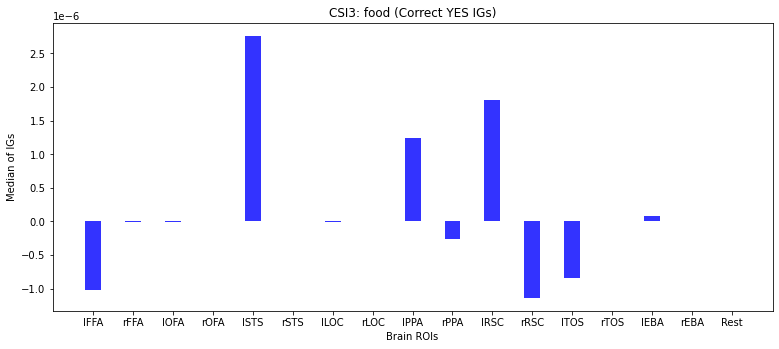

In [36]:
j = 97 # food
plot_all(sub, j)

p_80 1.395480194332778e-05
p_20 -1.2012025399599222e-05


p_80 3.817039760178888e-06
p_20 -4.449273546924814e-06




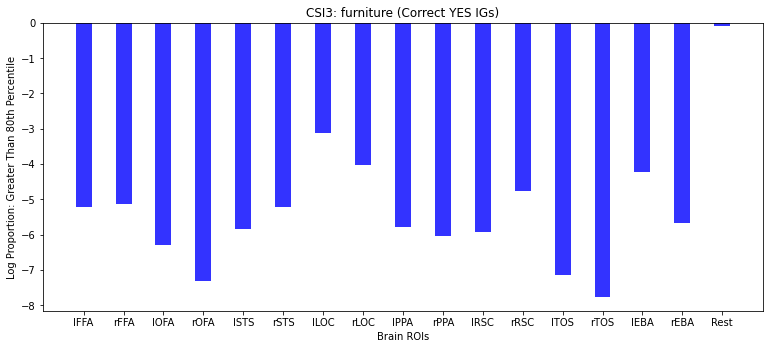

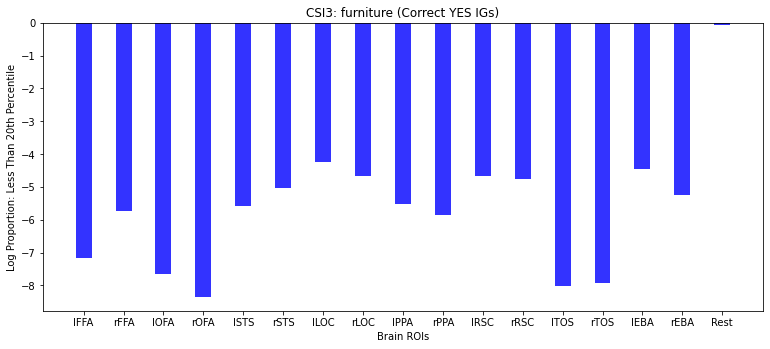

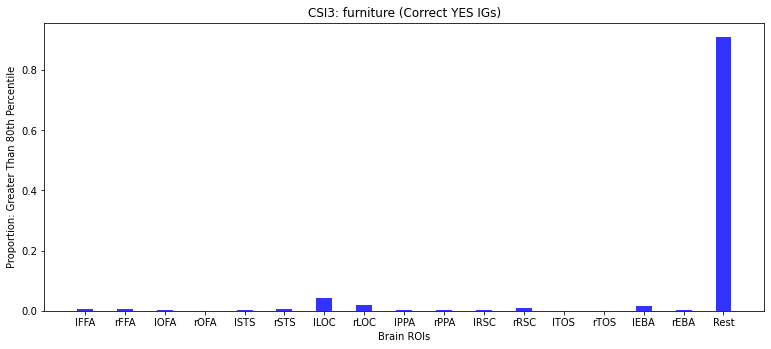

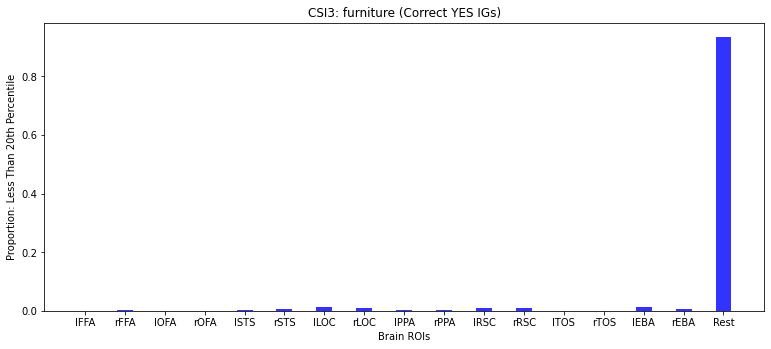

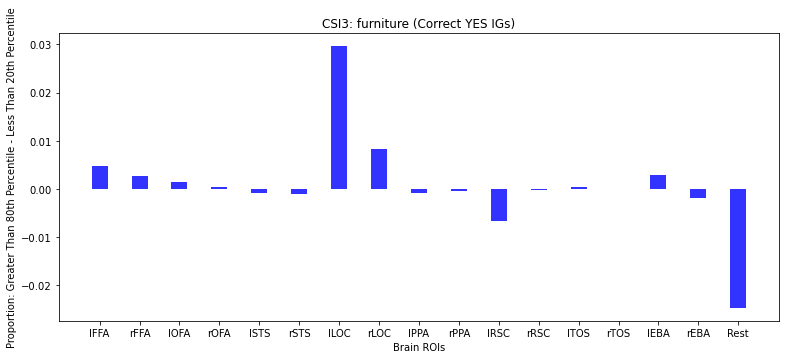

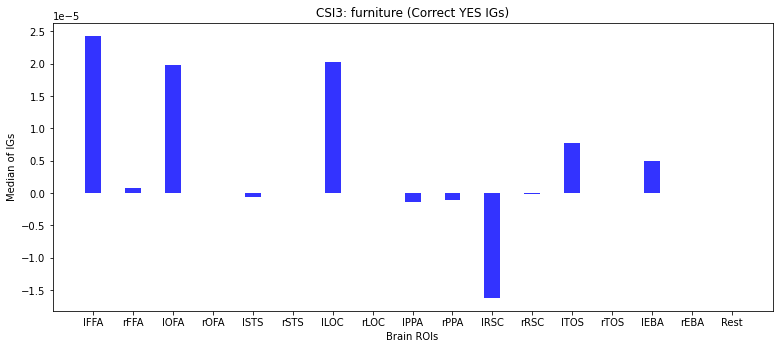

In [37]:
j = 98 # furniture
plot_all(sub, j)

In [38]:
# j = 102 # tool
# plot_all(sub, j)